# check speedysedfit fit command (speedysedfit/main.py -->perform_fit(args))

In [1]:
import yaml
from speedysedfit.main import get_observations, fit_sed
from speedysedfit.model import get_grid_file, prepare_grid, _get_flux_from_table
from speedysedfit import filters
from astropy.io import fits
import numpy as np

In [2]:
setup_file = 'TYC3340-2437-1_setup_binary.yaml'
ifile = open(setup_file)
setup = yaml.safe_load(ifile)
ifile.close()

pnames = setup['pnames']
limits = np.array(setup['limits'])

constraints = setup['constraints']
for con, val in list(constraints.items()):
    if len(val) == 2:
        constraints[con] = [val[0], val[1], val[1]]
if 'parallax' in constraints:
    p, pm, pp = constraints.pop('parallax')
    constraints['distance'] = [1000. / p, 1000. * pm / p ** 2, 1000. * pp / p ** 2]
print("Applied constraints: ")
for con, val in list(constraints.items()):
    print("\t {} = {} - {} + {}".format(con, val[0], val[1], val[2]))
if 'distance' in constraints:
    # convert pc to Rsol
    constraints['distance'] = [44365810.04823812 * constraints['distance'][0],
                               44365810.04823812 * constraints['distance'][1],
                               44365810.04823812 * constraints['distance'][2], ]
derived_limits = setup['derived_limits']

Applied constraints: 
	 distance = 3012.0481927710844 - 160.5820873856873 + 160.5820873856873


In [3]:
from speedysedfit.default_setup import default_binary, default_single

In [4]:
out = default_single

In [5]:
out

"\n# photometry file with index to the columns containing the photbands, observations and errors\nobjectname: <objectname>\nphotometryfile: <photfilename>\nphotband_index: band\nobs_index: flux\nerr_index: eflux\nphotband_exclude: <photband_exclude>\n# parameters to fit and the limits on them in same order as parameters\npnames: [teff, logg, rad, ebv]\nlimits: \n<parameter_limits>\n# constraints on distance and mass ratio is known\nconstraints: <constraints>\n# added constraints on derived properties as mass, luminosity, luminosity ratio\nderived_limits: {}\n# path to the model grids with integrated photometry\ngrids: \n<model_grids>\n# setup for the MCMC algorithm\nnwalkers: 100    # total number of walkers\nnsteps: 1000     # steps taken by each walker (not including burn-in)\nnrelax: 250      # burn-in steps taken by each walker\na: 10            # relative size of the steps taken\n# set the percentiles for the error determination \npercentiles: [16, 50, 84] # 16 - 84 corresponds to

In [6]:
photbands, obs, obs_err = get_observations(setup)

In [7]:
#results, samples, constraints, gridnames = fit_sed(setup, photbands, obs, obs_err)  

In [8]:
import os
os.path.exists

<function genericpath.exists(path)>

In [9]:
gridnames = setup['grids']
print(gridnames)

['kurucz', 'kurucz']


In [10]:
grids = []
for i, name in enumerate(gridnames):
    ind = '' if i == 0 else str(i + 1)

    axis_values, grid_pars, pixelgrid, grid_names = prepare_grid(photbands, name,
                                                                 teffrange=limits[pnames.index('teff' + ind)],
                                                                 loggrange=limits[pnames.index('logg' + ind)],
                                                                 ebvrange=limits[pnames.index('ebv')],
                                                                 variables=['teff', 'logg', 'ebv'])

    grids.append([axis_values, pixelgrid])

/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/interpol.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pixelgrid[indices] = grid_data.T


In [11]:
limits

array([[3.0618e+04, 3.0618e+04],
       [3.8100e+00, 3.8100e+00],
       [8.0000e+00, 1.5000e+01],
       [2.7000e+04, 2.7000e+04],
       [4.0000e+00, 4.0000e+00],
       [8.0000e+00, 1.5000e+01],
       [1.0000e+00, 1.6000e+00]])

In [12]:
teffrange=limits[pnames.index('teff' + ind)]
loggrange=limits[pnames.index('logg' + ind)]
ebvrange=limits[pnames.index('ebv')]
variables=['teff', 'logg', 'ebv']

In [13]:
flux = []
grid_pars = []
grid_names = np.array(variables)

gridfilename = get_grid_file(integrated=True, grid='kurucz')

with fits.open(gridfilename) as ff:
    # -- make an alias for further reference
    ext = ff[1]

    # -- the grid is already cut here to limit memory usage
    keep = np.ones(len(ext.data), bool)
    for name in variables:
        # -- first find the closest actuall grid points
        low, high = locals()[name + 'range']
        print(name, low, high)
        lidx = np.abs(ext.data.field(name)[ext.data.field(name) <= low] - low).argmin()
        hidx = np.abs(ext.data.field(name)[ext.data.field(name) >= high] - high).argmin()
        low = ext.data.field(name)[ext.data.field(name) <= low][lidx]
        high = ext.data.field(name)[ext.data.field(name) >= high][hidx]

        # -- we need to be carefull for rounding errors
        in_range = (low <= ext.data.field(name)) & (ext.data.field(name) <= high)
        on_edge = np.allclose(ext.data.field(name), low) | np.allclose(ext.data.field(name), high)

        keep = keep & (in_range | on_edge)

    grid_pars = np.vstack([ext.data.field(name)[keep] for name in variables])
    flux = _get_flux_from_table(ext, photbands, include_Labs=True)[keep]

flux = np.log10(flux)

# -- create the pixeltype grid
axis_values, pixelgrid = interpol.create_pixeltypegrid(grid_pars, flux.T)



teff 27000.0 27000.0
logg 4.0 4.0
ebv 1.0 1.6


NameError: name 'interpol' is not defined

In [14]:
ff = fits.open(gridfilename)
ext = ff[1]
lidx = np.abs(ext.data.field(name)[ext.data.field(name) <= low] - low).argmin()

In [15]:
_get_flux_from_table(ext, photbands, include_Labs=True)[keep]

array([[2.05061293e+07, 2.11189053e+07, 1.94337276e+07, 2.04625145e+07,
        2.10071814e+07, 1.95783810e+07, 1.91371936e+07, 2.19594712e+07,
        2.03655675e+07, 2.23134241e+07, 2.06404783e+07, 8.80985752e+06,
        3.87712527e+06, 1.58318120e+06, 3.21955853e+05, 9.57724976e+04,
        4.79334258e+02],
       [1.83381058e+07, 1.82214007e+07, 1.79000682e+07, 1.83026926e+07,
        1.81013378e+07, 1.80202194e+07, 1.58394572e+07, 1.90509887e+07,
        1.71770633e+07, 1.98294604e+07, 1.89289159e+07, 8.50373579e+06,
        3.79666967e+06, 1.56311169e+06, 3.20039439e+05, 9.54394779e+04,
        4.79334258e+02],
       [1.64220944e+07, 1.57361100e+07, 1.64919400e+07, 1.63936621e+07,
        1.56130371e+07, 1.65902138e+07, 1.31122769e+07, 1.65299808e+07,
        1.44917864e+07, 1.76238233e+07, 1.73602500e+07, 8.20835243e+06,
        3.71789600e+06, 1.54329820e+06, 3.18134688e+05, 9.51076291e+04,
        4.79334258e+02],
       [1.47261186e+07, 1.36022233e+07, 1.51987178e+07, 1.470

In [16]:
photbands

array(['GAIA3E.G', 'GAIA3E.BP', 'GAIA3E.RP', 'GAIA2.G', 'GAIA2.BP',
       'GAIA2.RP', 'APASS.B', 'APASS.V', 'APASS.G', 'APASS.R', 'APASS.I',
       '2MASS.J', '2MASS.H', '2MASS.KS', 'WISE.W1', 'WISE.W2'],
      dtype='<U9')

In [17]:
ext

In [18]:
variables=['teff', 'logg', 'ebv']

In [12]:
from speedysedfit import photometry_query

In [13]:
objectname = setup['objectname']

In [14]:
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.utils.tap.core import TapPlus
import pyvo

from astropy import units as u
from astropy.coordinates.angles import Angle
from astropy.coordinates import SkyCoord
from astropy.io import ascii

from numpy.lib.recfunctions import append_fields

In [50]:
objectname = 'TYC3340-2437-1'

# check query parallax 

In [51]:
from zero_point import zpt
v_gaia = Vizier(columns=["Plx", "e_Plx", '+_r', 'Gmag', 'nueff', 'pscol', 'ELAT', 'Solved'])
data = v_gaia.query_object(objectname, catalog=['I/350/gaiaedr3'], radius=5*u.arcsec)
data = data['I/350/gaiaedr3'][0]
zp = zpt.get_zpt(data['Gmag'], data['nueff'], data['pscol'], data['ELAT'], data['Solved'])

/home/lijiao/anaconda3/lib/python3.7/site-packages/zero_point/zpt.py:163: UserWarning: Warning: converting a masked element to nan.
  pseudocolour = np.array([pseudocolour])


In [54]:
0.3320 - zp

0.364648

In [52]:
data

Plx,e_Plx,_r,Gmag,nueff,pscol,ELAT,Solved
mas,mas,arcmin,mag,1 / um,um,deg,
float64,float32,float64,float64,float32,float64,float64,int16
0.3320,0.0177,0.0004,10.907856,1.433,--,29.0802625275,31


# check query photomety

In [22]:
import os

import configparser
import warnings

import numpy as np

from speedysedfit import filters

from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.utils.tap.core import TapPlus
import pyvo

from astropy import units as u
from astropy.coordinates.angles import Angle
from astropy.coordinates import SkyCoord
from astropy.io import ascii

from numpy.lib.recfunctions import append_fields


filedir = '/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/'
v = Vizier(columns=["*", '+_r'])

#-- read in catalog information
viz_info = configparser.ConfigParser()
viz_info.optionxform = str # make sure the options are case sensitive
#viz_info.readfp(open(filedir+'/vizier_cats_phot.cfg'))
viz_info.read_file(open(filedir+'/vizier_cats_phot.cfg'))


tap_info = configparser.ConfigParser()                                                                                                                                    
tap_info.optionxform = str # make sure the options are case sensitive
tap_info.read_file(open(filedir+'/tap_cats_phot.cfg'))


from speedysedfit.photometry_query import get_coordinate, get_tap_photometry, get_vizier_photometry, tap_query_vo
objectname = 'Feige64'
ra, dec = get_coordinate(objectname)
try:
   photometry_tap = get_tap_photometry(ra, dec)
except Exception as e:
   print(e)
   photometry_tap = None
photometry_ = get_vizier_photometry(objectname, radius=5)

if photometry_tap is None:
   photometry = photometry_
else:  photometry = np.hstack([photometry_tap, photometry_]) 

dr1.master
problem Missing REQUEST paramater.
error of http://api.skymapper.nci.org.au/public/tap/:  Missing REQUEST paramater.
dbo.DetectionObjectView
problem ConnectionError: HTTPConnectionPool(host='vao.stsci.edu', port=80): Max retries exceeded with url: /PS1DR2/TapService.aspx//sync (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f26101e1d90>: Failed to establish a new connection: [Errno -2] Name or service not known'))
error of http://vao.stsci.edu/PS1DR2/TapService.aspx/:  Exception translating ADQL: Geometry query requested for non-indexed table.
I/350/gaiaedr3
I/345/gaia2
II/336/apass9
II/246/out
II/335/galex_ais
V/139/sdss9
II/311/wise


/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/photometry_query.py:110: UserWarning: Warning: converting a masked element to nan.
  photometry = np.array(photometry, dtype=dtypes)


In [23]:
photometry_ = get_vizier_photometry(objectname, radius=5)

I/350/gaiaedr3
I/345/gaia2
II/336/apass9
II/246/out
II/335/galex_ais
V/139/sdss9
II/311/wise


/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/photometry_query.py:110: UserWarning: Warning: converting a masked element to nan.
  photometry = np.array(photometry, dtype=dtypes)


In [25]:
photometry = np.array([])
photometry1 = np.hstack([photometry, photometry_])

TypeError: invalid type promotion

In [26]:
catalogs = tap_info.sections()
catalogs

['http://api.skymapper.nci.org.au/public/tap/',
 'http://vao.stsci.edu/PS1DR2/TapService.aspx/']

In [27]:
#catalogs[0] = 'http://skymappertap.asvo.nci.org.au/ncitap/tap/'
#https://api.skymapper.nci.org.au/public/tap/

In [28]:
#phot_ = tap_query_vo(ra, dec, catalogs[0])
catalog = catalogs[1]
#service = pyvo.dal.TAPService('http://vao.stsci.edu/PS1DR1BestTAP/TapService.aspx/')
service = pyvo.dal.TAPService(catalog)

In [29]:
print(catalog)
print('http://api.skymapper.nci.org.au/public/tap')

http://vao.stsci.edu/PS1DR2/TapService.aspx/
http://api.skymapper.nci.org.au/public/tap


In [30]:
table = tap_info.get(catalog, 'table')

In [31]:
table = 'dbo.DetectionObjectView'

In [32]:
keywords = ""
bands = []
for band in tap_info.options(catalog):
    if 'table' in band: continue
    if 'rakw' in band: continue
    if 'deckw' in band: continue
    if '_unit' in band: continue
    if '_err' in band: continue
    if 'bibcode' in band: continue
    errkw = tap_info.get(catalog, band + '_err') if tap_info.has_option(catalog, band + '_err') else 'e_' + band
    keywords += band + ", " + errkw + ", "
    bands.append(band)
if keywords[-2:] == ", ":
    keywords = keywords[0:-2]
rakw = tap_info.get(catalog, 'rakw') if tap_info.has_option(catalog, 'rakw') else 'raj2000'
deckw = tap_info.get(catalog, 'deckw') if tap_info.has_option(catalog, 'deckw') else 'dej2000'


In [33]:
tap_info.options(catalog)

['table',
 'rakw',
 'deckw',
 'gMeanPSFMag',
 'gMeanPSFMag_unit',
 'gMeanPSFMag_err',
 'rMeanPSFMag',
 'rMeanPSFMag_unit',
 'rMeanPSFMag_err',
 'iMeanPSFMag',
 'iMeanPSFMag_unit',
 'iMeanPSFMag_err',
 'zMeanPSFMag',
 'zMeanPSFMag_unit',
 'zMeanPSFMag_err',
 'yMeanPSFMag',
 'yMeanPSFMag_unit',
 'yMeanPSFMag_err',
 'bibcode']

In [34]:
query = """SELECT 
         {kws:}
         FROM {table:} AS m
         WHERE 
            1=CONTAINS(POINT('ICRS', {rakw:}, {deckw}),
                     CIRCLE('ICRS', {ra:}, {dec:}, 0.005 ))
         """.format(ra=ra, dec=dec, table=table, rakw=rakw, deckw=deckw, kws=keywords)
print(query)

SELECT 
         gMeanPSFMag, gMeanPSFMagErr, rMeanPSFMag, rMeanPSFMagErr, iMeanPSFMag, iMeanPSFMagErr, zMeanPSFMag, zMeanPSFMagErr, yMeanPSFMag, yMeanPSFMagErr
         FROM dbo.DetectionObjectView AS m
         WHERE 
            1=CONTAINS(POINT('ICRS', raMean, decMean),
                     CIRCLE('ICRS', 187.56216458333333, 46.622190555555555, 0.005 ))
         


In [35]:
results = service.run_sync(query)

DALQueryError: Exception translating ADQL: Geometry query requested for non-indexed table.

# check create_setup_by_parameters

In [36]:
from speedysedfit import model
ranges = model.get_grid_ranges(grid='kurucz')

In [37]:
from speedysedfit.main import create_setup_by_parameters
object_name = 'TYC3340-2437-1'
#create_setup_by_parameters(object_name, teff1=30616, teff1_err=260, logg1=3.81, logg1_err=0.03,
#                                teff2 = None, teff2_err=None, logg2=None, logg2_err=None,
#                                grids=['kurucz', 'tmp'], ebv= [0, 2],
#                                binary=False, parallax=True, direout='./')

# check perform_fit_parameters

In [38]:
import yaml
from speedysedfit.main import get_observations
import os
import numpy as np
from speedysedfit import statfunc, model, filters
setup_file = 'TYC3340-2437-1/TYC3340-2437-1_setup_kurucz.yaml'
ifile = open(setup_file)
setup = yaml.safe_load(ifile)
ifile.close()

setup['photometryfile'] = os.path.join(os.path.dirname(setup_file), setup['photometryfile'])

ScannerError: sequence entries are not allowed here
  in "TYC3340-2437-1/TYC3340-2437-1_setup_kurucz.yaml", line 12, column 16

# check fit_sed_parameters

In [39]:
photbands, obs, obs_err = get_observations(setup)
pnames = setup['pnames']
limits = np.array(setup['limits'])

# -- check for variables that are kept fixed
fixed = np.where(limits[:, 0] == limits[:, 1])
varied = np.where(limits[:, 0] != limits[:, 1])
pnames = np.array(pnames)
fixed_variables = {}
for par, val in zip(pnames[fixed], limits[:, 0][fixed]):
    fixed_variables[par] = val
pnames = list(pnames[varied])
limits = limits[varied]


In [40]:
pnames, setup['constraints']


(['rad', 'rad2', 'ebv'],
 {'distance': [133631957976.62085, 7124354386.102977, 7124354386.102977]})

In [41]:
colors = np.array([filters.is_color(photband) for photband in photbands], bool)

In [42]:
nwalkers = 10
pos = [ np.random.uniform(lim[0], lim[1], nwalkers) for lim in limits]
pos = np.array(pos).T

In [43]:
 # -- pars constraints
 constraints = setup['constraints']
 for con, val in list(constraints.items()):
     if len(val) == 2:
         constraints[con] = [val[0], val[1], val[1]]
 if 'parallax' in constraints:
     p, pm, pp = constraints.pop('parallax')
     constraints['distance'] = [1000. / p, 1000. * pm / p ** 2, 1000. * pp / p ** 2]
 print("Applied constraints: ")
 for con, val in list(constraints.items()):
     print("\t {} = {} - {} + {}".format(con, val[0], val[1], val[2]))
 if 'distance' in constraints:
     # convert pc to Rsol
     constraints['distance'] = [44365810.04823812 * constraints['distance'][0],
                                44365810.04823812 * constraints['distance'][1],
                                44365810.04823812 * constraints['distance'][2], ]
 # -- pars limits on derived properties
 derived_limits = setup['derived_limits']


Applied constraints: 
	 distance = 133631957976.62085 - 7124354386.102977 + 7124354386.102977


In [44]:
gridnames = setup['grids']
grids = model.load_grids(gridnames, pnames, limits, photbands)


ValueError: 'teff' is not in list

In [13]:
kwargs = {'pnames':pnames,
          'colors':colors,
          'grid':grids,
          'fixed_variables':fixed_variables,
          'constraints':constraints,
          'derived_limits':derived_limits,
          'prop_func': statfunc.get_derived_properties}


Applied constraints: 
	 teff = 30616.0 - 260.0 + 260.0
	 logg = 3.81 - 0.03 + 0.03
	 distance = 2742.7317608337908 - 133.1496219603897 + 133.1496219603897


/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/interpol.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pixelgrid[indices] = grid_data.T
/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/statfunc.py:302: RuntimeWarning: invalid value encountered in multiply
  chisq = np.where(colors, (syn - meas) ** 2 / e_meas ** 2, (syn * scale - meas) ** 2 / e_meas ** 2)
/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/mcmc.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  extra_drv['d'] = np.sqrt(1/scales)/44365810.04823812
  0%|          | 0/1250 [00:00<?, ?it/s]

processes = 1


/home/lijiao/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1250/1250 [01:16<00:00, 16.30it/s]


Multiprocessing took 76.8 seconds
['kurucz']

Resulting parameter values and errors:
   Par             Best        Pc       emin       emax
   teff       =   29653     29653   -    267   +    265
   logg       =    3.86      3.86   -   0.03   +   0.03
   rad        =   10.21     10.29   -   0.47   +   0.57
   ebv        =   1.213     1.213   -  0.002   +  0.002
   mass       =   27.37     27.87   -   3.19   +   3.73
   d          =    2742      2762   -    126   +    150
   L          = 72748.87   73870.10   -6807.28   +8366.59
   scale      =   0.000     0.000   -  0.000   +  0.000
   chi2       = 1319.206   1322.681   -  2.013   +  3.259


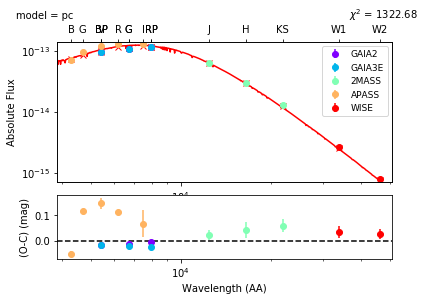

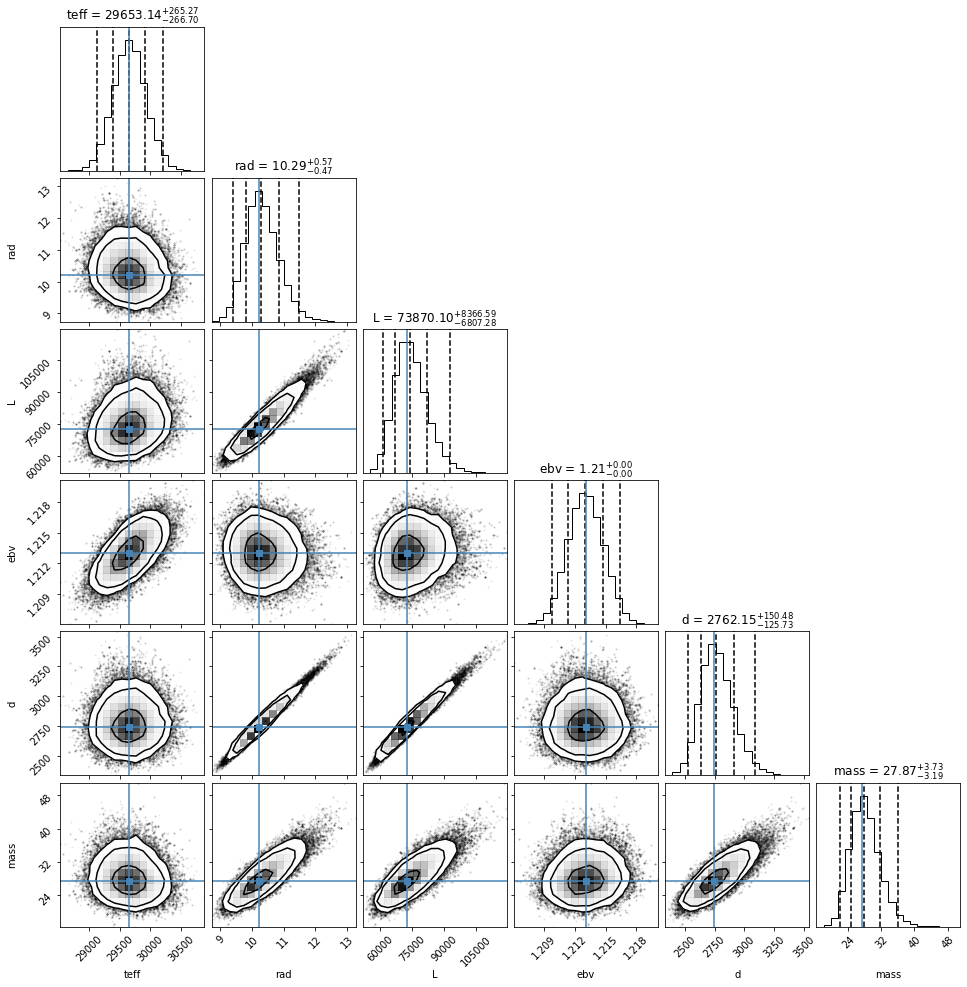

In [1]:
#from importlib import reload  
from speedysedfit.main import perform_fit_parameters
setup_file = 'TYC3340-2437-1/TYC3340-2437-1_setup_kurucz.yaml'
perform_fit_parameters(setup_file, processes=1, noplot=False)

Applied constraints: 
	 teff = 30616.0 - 260.0 + 260.0
	 logg = 3.81 - 0.03 + 0.03
	 distance = 2742.7317608337908 - 133.1496219603897 + 133.1496219603897


/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/interpol.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pixelgrid[indices] = grid_data.T
/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/statfunc.py:302: RuntimeWarning: invalid value encountered in multiply
  chisq = np.where(colors, (syn - meas) ** 2 / e_meas ** 2, (syn * scale - meas) ** 2 / e_meas ** 2)
/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/statfunc.py:302: RuntimeWarning: invalid value encountered in multiply
  chisq = np.where(colors, (syn - meas) ** 2 / e_meas ** 2, (syn * scale - meas) ** 2 / e_meas ** 2)
/home/lijiao/anaconda3/lib/python3.7/site-packages/spe

processes = 10


/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/statfunc.py:302: RuntimeWarning: invalid value encountered in multiply
  chisq = np.where(colors, (syn - meas) ** 2 / e_meas ** 2, (syn * scale - meas) ** 2 / e_meas ** 2)
/home/lijiao/anaconda3/lib/python3.7/site-packages/speedysedfit-0.1.0-py3.7.egg/speedysedfit/mcmc.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  extra_drv['d'] = np.sqrt(1/scales)/44365810.04823812
/home/lijiao/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1250/1250 [00:18<00:00, 68.41it/s]


Multiprocessing took 18.3 seconds
['kurucz']

Resulting parameter values and errors:
   Par             Best        Pc       emin       emax
   teff       =   29614     29640   -    253   +    265
   logg       =    3.86      3.86   -   0.03   +   0.03
   rad        =   10.23     10.30   -   0.48   +   0.53
   ebv        =   1.213     1.213   -  0.002   +  0.002
   mass       =   27.68     27.91   -   3.13   +   3.68
   d          =    2745      2764   -    127   +    140
   L          = 72698.75   73834.07   -6725.51   +8050.45
   scale      =   0.000     0.000   -  0.000   +  0.000
   chi2       = 1319.231   1322.609   -  1.957   +  3.254


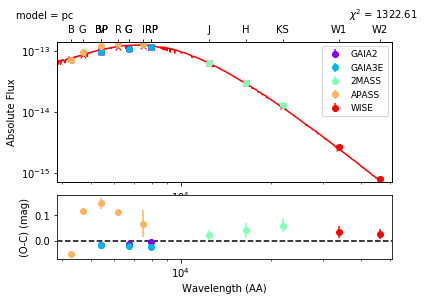

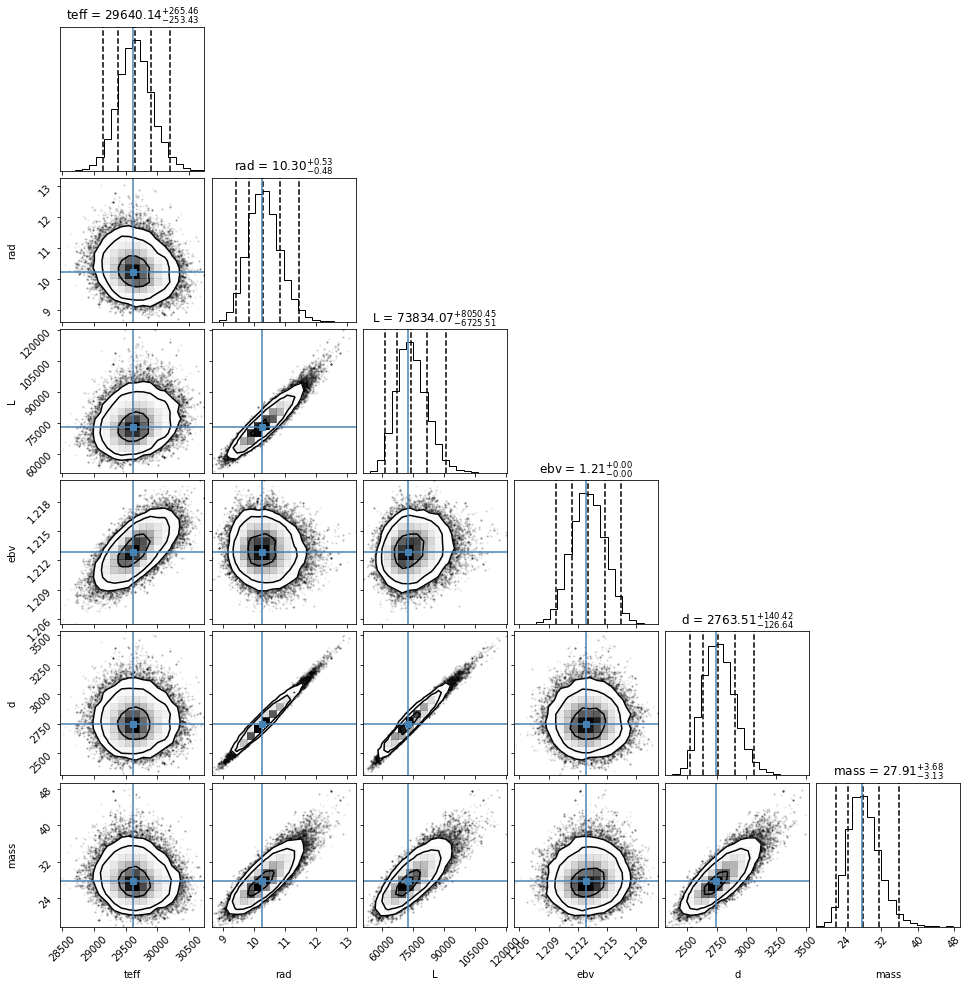

In [2]:
from speedysedfit.main import perform_fit_parameters
setup_file = 'TYC3340-2437-1/TYC3340-2437-1_setup_kurucz.yaml'
perform_fit_parameters(setup_file, processes=10, noplot=False)

In [36]:
'teff' in constraints

True

In [17]:
kwargs['constraints']

{'teff': [30616.0, 260.0, 260.0],
 'logg': [3.81, 0.03, 0.03],
 'distance': [121683516314.42163, 5907290835.889365, 5907290835.889365]}